In [2]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm

Load and clean the dataset

In [3]:
df = pd.read_csv('WHO/ledata.csv')
df = df.dropna()

del df['Country']
del df['Year']
del df['Status']

y = df['Life expectancy '].to_numpy()

del df['Life expectancy ']

A = df.to_numpy()

n_train = 1349

A_train = A[:1349:]
y_train = y[:1349]

A_test = A[1349::]
y_test = y[1349:]

print(A_train.shape)

## data normalization 

mA = A_train.mean(axis=0)
sA = A_train.std(axis=0)


A_train = (A_train-mA)/sA
A_test = (A_test-mA)/sA

m = y_train.mean()
y_train = y_train-m
y_test = y_test-m

(1349, 18)


In [4]:
### Gradient descent

def grad_desc(A,y,eps=1e-2,lr = None,lamb= 0,verbose=0,itemax=170):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])
    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    while np.all(np.abs(grad) > eps) and ite<itemax:
        y_pred = A.dot(X)
        grad = np.dot(A.T,(y_pred-y))+2*lamb*X
        X = X - lr*grad 
        l_loss.append((1/2*(y_pred-y)**2+ lamb*np.sum(np.square(X))).mean())
        ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.show()
        
    return X,l_loss

In [70]:
### Stochastic gradient descent

def SGD(A,y,eps=1e-5,lr = None,verbose=0,epochs_max=10,batch_size=1):
    X = np.zeros(A.shape[1])
    N = A.shape[0]
    grad = np.array([1000]*A.shape[1])

    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    m_l = 0
    l_i = np.arange(len(y))
    while np.all(np.abs(grad) > eps) and ite<N*epochs_max:
        np.random.shuffle(l_i)
        
        for batch_start in range(0,len(y),batch_size):
            
            batch_end =batch_start+batch_size
            i = l_i[batch_start:batch_end]
            y_pred = A[i,:].dot(X)           
            grad =  np.dot(A[i,:].T,(y_pred-y[i]))
            X = X - lr*grad 
            
            m_l*=ite
            m_l+= (1/2*(y_pred-y[i])**2).mean()
            m_l/=(ite+1)
            l_loss.append(m_l)
            ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('mean loss')
        plt.show()
        
    return X,l_loss

In [6]:
def score(X_n,A,y): #return the coeff of determination
    y_pred= A@X_n
    return 1-(((y_pred-y)**2).sum())/(((y-y.mean())**2).sum())

def loss(X_n,A,y):
    return np.mean(1/2*np.square(A@X_n-y))

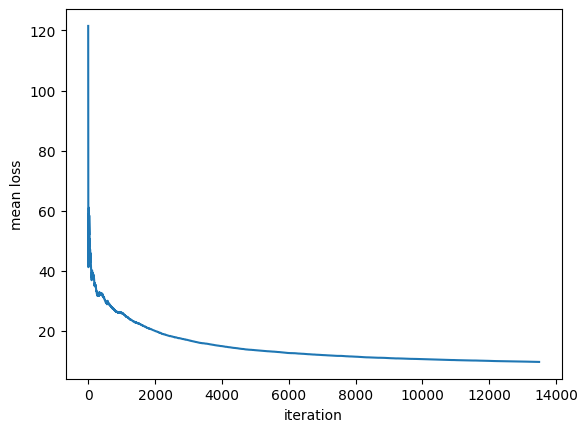

7.270176417616207


In [75]:
X,l_loss = SGD(A_train,y_train,eps=1e-3,verbose=1,batch_size=1)
print(loss(X,A_test,y_test))

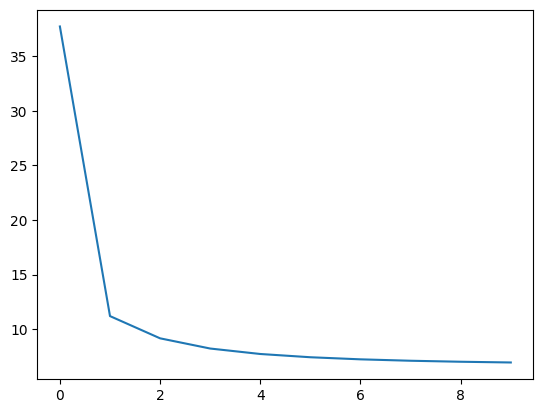

7.488031614413612


In [19]:
X,l_loss = grad_desc(A_train,y_train,eps=1,verbose=1)

print(loss(X,A_test,y_test))

100%|██████████| 10/10 [04:15<00:00, 25.52s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


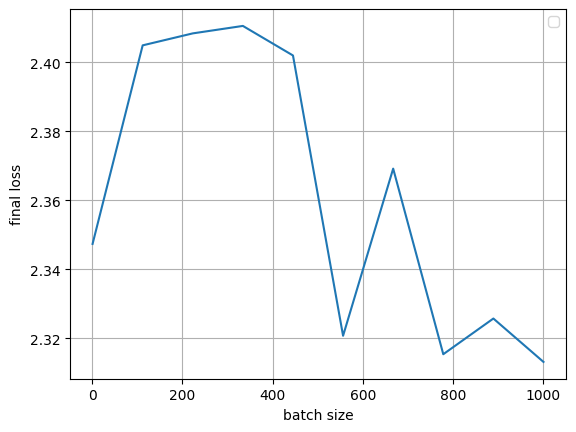

In [20]:
L_loss =[]
l_i = np.linspace(1,1000,10)
l_i = [int(i) for i in l_i]
for i in tqdm(l_i):
    mean = 0
    for k in range(30):
        X_n,l_loss = SGD(A_train,y_train,eps=1e-3,batch_size=i)
        mean+=loss(X_n,A_test,y_test)
    L_loss.append(mean/100)


plt.figure(1)
plt.plot(l_i,L_loss)
plt.xlabel('batch size')
plt.ylabel('final loss')
plt.xlim()
plt.ylim()
plt.grid()
plt.legend()
plt.show()

In [98]:
### SVRG

def SVRG(A,y,eps=1e-2,lr = None,verbose=0,itemax=100,m=1):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])
    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   
    n = len(y)
    l_loss = []
    ite = 0
    while np.all(np.abs(grad) > eps) and ite<itemax:
        y_pred = A.dot(X)
        grad = np.dot(A.T,(y_pred-y))
        mu = grad.mean()
        l_i = list(range(n))
        X2 = X
        for j in range(m):
            rd.shuffle(l_i)
            i = l_i.pop()
            y_pred2 = A[i,:].dot(X2)
            grad2 =  np.dot(A[i,:].T,(y_pred2-y[i]))
            y_pred3 = A[i,:].dot(X)
            grad3 =  np.dot(A[i,:].T,(y_pred3-y[i]))
            X2 = X2 - lr*(grad2-grad3+mu)
        X = X2
        l_loss.append((1/2*(y_pred-y)**2).mean())
        ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.show()
        
    return X,l_loss

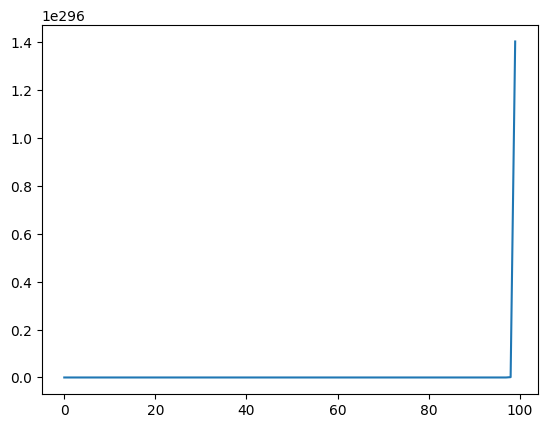

1.2209383865688907e+299


In [102]:
X,l_loss = SVRG(A_train,y_train,eps=1,verbose=1,m=100)
print(loss(X,A_test,y_test))

In [77]:
### SAGA Method

def SAGA(A,y,eps=1e-2,lr = None,verbose=0,epochs_max=10):
    N = A.shape[0]
    X = np.random.rand(A.shape[1])
    l_loss = []
    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   
    ite = 0
    grad = np.zeros([N,A.shape[1]])
    for i in range(N):
        y_pred2 = A[i,:].dot(X)
        grad2 =  np.dot(A[i,:].T,(y_pred2-y[i]))
        grad[i,:]=grad2

    l_i = list(range(N))
    rd.shuffle(l_i)

    m_l = 0
    while np.all(np.abs(grad) >= eps) and ite<epochs_max*N:

        if len(l_i)==0:
            l_i = list(range(N))
            rd.shuffle(l_i)     

        i = l_i.pop()
        y_pred2 = A[i,:].dot(X)
        grad2 =  np.dot(A[i,:].T,(y_pred2-y[i]))
        X = X - lr*(grad2-grad[i,:]+grad.mean(axis=0))
        grad[i,:] = grad2
        m_l*=ite
        m_l+= (1/2*(y_pred2-y[i])**2).mean()
        m_l/=(ite+1)
        l_loss.append(m_l)
        ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('mean loss')
        plt.show()
        
    return X,l_loss

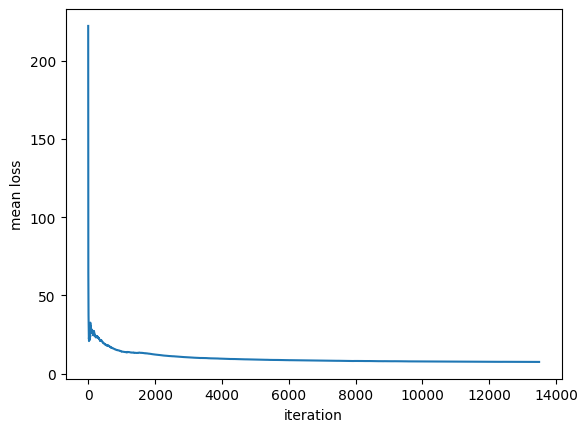

8.12581317813667


In [83]:
X,l_loss = SAGA(A_train,y_train,eps=0.00,lr=0.001,verbose=1)
print(loss(X,A_test,y_test))